<center><img src="./images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# ML through Application
## Module 3, Lab 2, Notebook 2: Exploring Model Predictions for Bias

This notebook shows you how to build a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict whether an individual's income is $\leq$ 50k by using data from the U.S. Census Bureau.

You will learn how to do the following:
- Build a simple classifier by using a scikit-learn pipeline and ColumnTransformer.
- Evaluate the classifier by using fairness metrics.
- Compare bias in data before training and bias in the model predictions.

__Dataset:__
You will use [Folktables](https://github.com/zykls/folktables) to download a dataset for this lab. Folktables provides an API to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files, which the U.S. Census Bureau manages. The data itself is governed by the terms of use that are provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).

You will filter the ACS PUMS data sample to include only individuals who are above the age of 16, reported usual working hours of at least 1 hour per week in the past year, and have an income of at least \\$100.
The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable replacement to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult), but the income threshold can be changed easily to define new prediction tasks. Historically, the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) served as the basis for the development and comparison of many algorithmic fairness interventions but has limited documentation, outdated feature encodings, and only contains a binary target label which can lead to misrepresentations for certain subpopulations. In order to compare your results with scientific findings that utilize the UCI Adult dataset, and to have greater control and flexibility in setting up the problem, you will utilize the ACS PUMS data with the filters and thresholds described above.

__ML problem:__
The goal is to predict whether an individual's income is above \\$50,000.
This is a binary prediction task that can enable organizations and businesses to target their marketing efforts more effectively. Alternatively, governments could leverage these predictions to design better social welfare programs and allocate resources efficiently. Keep these kinds of problems in mind, when working through the notebook.

Reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

----

You will be presented with activities throughout the notebook: <br/>

| <img style="float: center;" src="./images/activity.png" alt="Activity" width="125"/>|
| --- |
|<p style="text-align:center;"> No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p>|

## Index

- [Read in the dataset](#Read-in-the-dataset)
- [Data processing](#Data-processing)
- [Train a classifier](#Train-a-classifier)
- [Test the classifier](#Test-the-classifier)
- [Calculate DPPL and accuracy difference](#Calculate-DPPL-and-accuracy-difference)

Before reading in the dataset, make sure to install and import all required libraries.

In [ ]:
# Use pip to install libraries
!pip install --no-deps -U -q -r requirements.txt

In [ ]:
# Import the libraries needed for the notebook

# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys

sys.path.append("..")
sys.path.insert(1, "..")
from MLUMLA_EN_M3_Lab2_quiz_questions import *

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

---
## Read in the dataset

Import the data from Folktables the same way you did in the previous notebook.

In [ ]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grandparents living with grandchildren
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, for example: fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

Perform basic data processing by creating a dataframe with the features and then filter the dataframe so it only contains data from groups 6 and 8.


In [ ]:
# Convert NumPy array to DataFrame
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modeling, use only two groups
df = df[df["RAC1P"].isin([6, 8])].copy(deep=True)

---
## Data processing

### EDA

Look at the number of rows, number of columns, and some simple statistics of the dataset.

In [ ]:
# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,0.0
27,23.0,2.0,21.0,5.0,2545.0,207.0,17.0,20.0,2.0,6.0,35.0,NaN,0.0
33,18.0,1.0,16.0,5.0,9610.0,6.0,17.0,8.0,2.0,6.0,33.0,NaN,0.0
46,40.0,1.0,15.0,3.0,4140.0,303.0,16.0,22.0,1.0,8.0,38.0,2.0,0.0
49,18.0,1.0,18.0,5.0,725.0,6.0,17.0,12.0,2.0,6.0,60.0,NaN,0.0


In [ ]:
# Check how many rows and columns are in the DataFrame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (55502, 13)


In [ ]:
# See the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  float64
 1   COW     55502 non-null  float64
 2   SCHL    55502 non-null  float64
 3   MAR     55502 non-null  float64
 4   OCCP    55502 non-null  float64
 5   POBP    55502 non-null  float64
 6   RELP    55502 non-null  float64
 7   WKHP    55502 non-null  float64
 8   SEX     55502 non-null  float64
 9   RAC1P   55502 non-null  float64
 10  PWGTP   55502 non-null  float64
 11  GCL     41987 non-null  float64
 12  >50k    55502 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB


Notice that all columns are numerical (`dtype = float64`). However, check the column headers (and information about the dataset from the links given at the beginning of the notebook), and notice that you are actually dealing with multimodal data. The dataset has a mix of categorical, numerical, and potentially even text information.

Cast the features accordingly. You start by creating a list for each feature type.

In [ ]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

In [ ]:
# Cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# Cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

To make sure that the changes took effect, use `.info()` to check. Compare the results to the `df.info()` output above to make sure the features were cast correctly.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  int64  
 1   COW     55502 non-null  object 
 2   SCHL    55502 non-null  object 
 3   MAR     55502 non-null  object 
 4   OCCP    55502 non-null  object 
 5   POBP    55502 non-null  object 
 6   RELP    55502 non-null  object 
 7   WKHP    55502 non-null  int64  
 8   SEX     55502 non-null  object 
 9   RAC1P   55502 non-null  object 
 10  PWGTP   55502 non-null  int64  
 11  GCL     41987 non-null  object 
 12  >50k    55502 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.9+ MB


Now you can now separate model features from the model target to explore them separately.

In [ ]:
model_target = ">50k"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [ ]:
# Check that the target is not accidentally part of the features
model_target in model_features

False

This looks good. You made sure that the target is not in the feature list. If the output of the previous cell is `True`, you need to remove the target by calling `model_features.remove(model_target)`.

Next, you will look at missing values.

#### Check for missing values

The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of missing values.

You can also see the count of missing values with `.info()` because the function provides a count of non-null values.

In [ ]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
>50k         0
dtype: int64

If you find a column where the majority of the values are missing, consider to exclude this column from the feature list. Alternatively, you can find a way to fill the missing values and impute them.

Before starting to create plots, look at how many unique instances you have per column. This helps you avoid plotting charts with hundreds of unique values. To do this, filter for columns with fewer than 10 unique instances.

In [ ]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    2.0
GCL      2.0
dtype: float64


#### Check the target distribution

Check the target distribution.

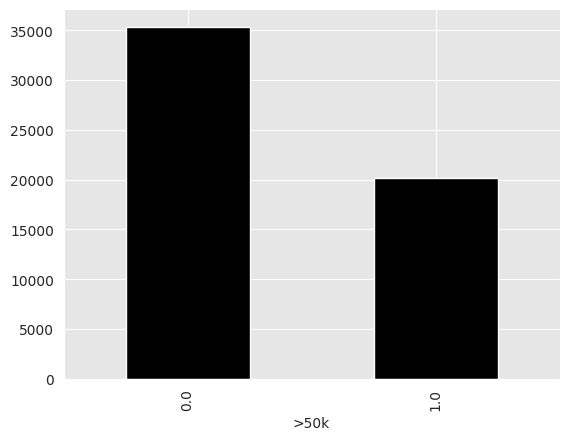

In [ ]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

Notice that the dataset is imbalanced. This means that the dataset has more examples for one type of result (here: 0; meaning individuals that earn $\leq$ 50k). This is relevant for model choice and potential upsampling or downsampling to balance out the classes.

#### Create feature distributions

Now, plot bar charts for the shortlist features (feature columns with fewer than 10 unique instance classes) of the dataset.

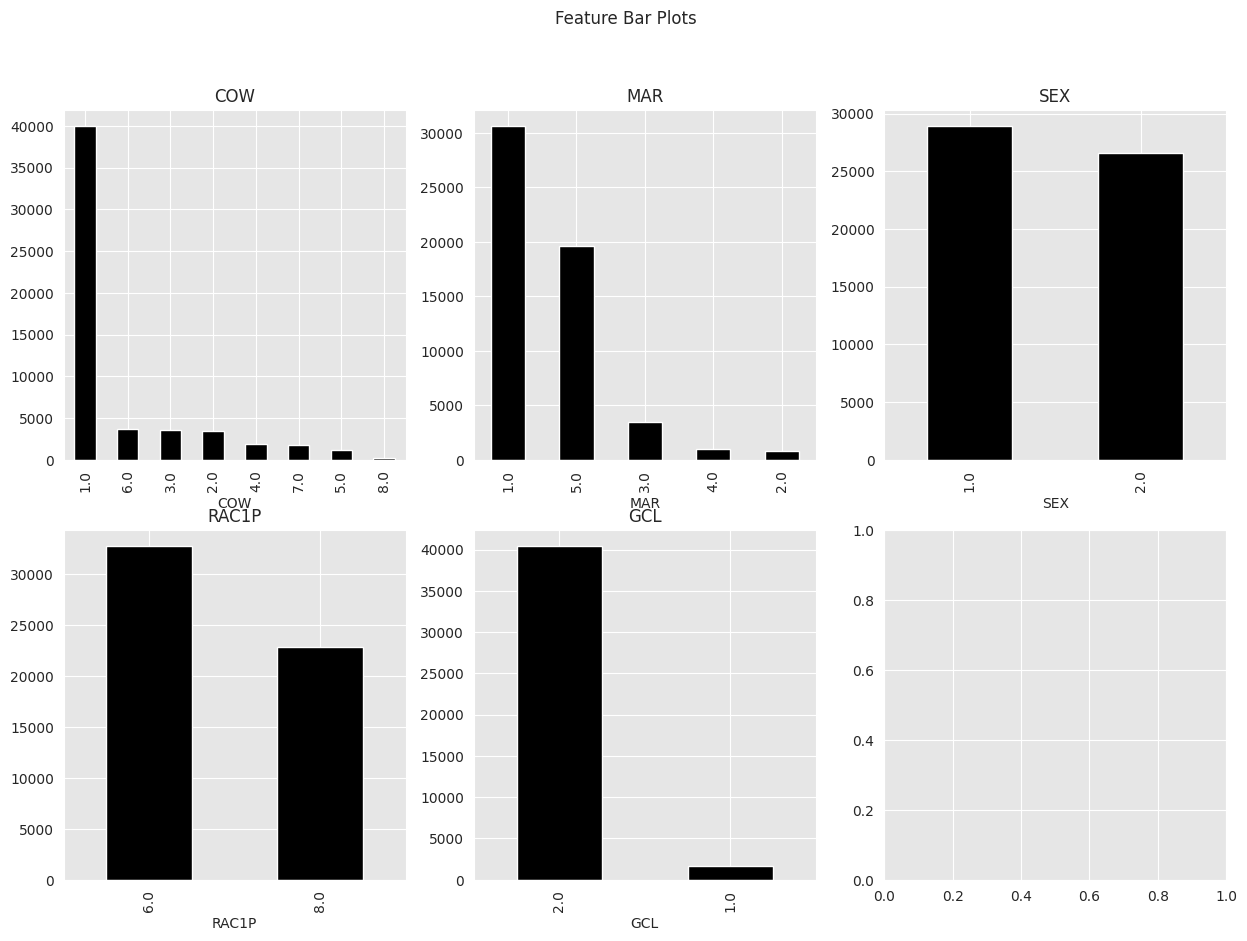

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Feature Bar Plots")

fts = range(len(shortlist_fts.index.tolist()))
for i, ax in zip(fts, axs.ravel()):
    df[shortlist_fts.index.tolist()[i]].value_counts().plot.bar(color="black", ax=ax)
    ax.set_title(shortlist_fts.index.tolist()[i])
plt.show()

### Select features to build the model

The GCL feature is equally present in both outcome instances and also contains a lot of missing values. Therefore, you can drop it from the list of features that you want to use for model build.

In [ ]:
to_remove = "GCL"

# Drop GCL feature from the respective list(s) - if applicable
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

# Clean up the DataFrame and only keep the features and columns that are needed
df = df[model_features + [model_target]].copy(deep=True)

### Create training, test, and validation datasets

To get training, test, and validation sets, use scikit-learn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [ ]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
)
train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the datasets
print(
    "Train - Test - Validation dataset shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation dataset shapes:  (42458, 12) (5551, 12) (7493, 12)


### Process the data with a pipeline and ColumnTransformer

Now you can build a full model pipeline. You need a preprocessing split per data type. Then, you will combine everything into a composite pipeline along with a model. To achieve this, you will use scikit-learn's `Pipeline` and `ColumnTransformer`.

__Step 1: Set up preprocessing per data type__

For the numerical features pipeline (`numerical_processor` in the following code cell), impute missing values with the mean by using scikit-learn's `SimpleImputer`. Then, use `MinMaxScaler` (you don't need to scale features when using decision trees, but it's a good idea to see how to use data transforms). If different processing is desired for different numerical features, you should build different pipelines, as shown for the two categorical text features.

In the categorical features pipeline, (`categorical_processor` in the following code cell), impute with a placeholder value and encode with scikit-learn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check unique values for categoricals to get an estimate of how many dummy features will be created by one-hot encoding. Note the `handle_unknown` parameter, which tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation or test set that was not present in the initial training set.

__Step 2: Combine preprocessing methods into a transformer__

The selective preparations of the dataset features are then put together into a collective `ColumnTransformer` to finally be used in a pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset through cross-validation or making predictions on a test dataset in the future.
   
__Step 3: Combine the transformer with a model__

Combine `ColumnTransformer` from step 2 with a selected algorithm in a new pipeline. For example, the algorithm could be a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for classification problems.

In [ ]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from step 1
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)

### STEP 3 ###
##############

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set or reach the parameters by using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(solver="liblinear", penalty="l2", C=0.001)),
    ]
)

# Visualize the pipeline
# This will be helpful, especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['AGEP', 'WKHP', 'PWGTP']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['COW', 'SCHL', 'MAR', 'OCCP',
                                                   'POBP', 'RELP', 'SEX',
                                                   'RAC1P'])])),
                ('lg', LogisticRegression(C=0.001, solver='liblinear'))])

---
## Train a classifier

Use the pipeline with the desired data transformers, along with a logistic regression estimator for training.

Train the classifier with `.fit()` on the training dataset.

In [ ]:
# Get training data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the training data
# Training data going through the pipeline is imputed (with means from the training data),
#   scaled (with the min/max from the training data),
#   and finally used to fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['AGEP', 'WKHP', 'PWGTP']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['COW', 'SCHL', 'MAR', 'OCCP',
                                                   'POBP', 'RELP', 'SEX',
                                                   'RAC1P'])])),
                ('lg', LogisticRegression(C=0.001, solver='liblinear'))])

In [ ]:
# Get validation data to tune the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

y_val_pred = pipeline.predict(X_val)

print("Model performance on the validation set:")
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

Model performance on the validation set:
Validation accuracy: 0.7795275590551181


---
## Test the classifier

Now, evaluate the performance of the trained classifier on the test dataset by using `.predict()`.

In [ ]:
# Get test data to validate the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Test data going through the pipeline is imputed (with means from the training data),
#   scaled (with the min/max from the training data),
#   and finally used to make predictions
test_predictions = pipeline.predict(X_test)

print("Model performance on the test set:")
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
Test accuracy: 0.7656278148081427


---
## Calculate DPPL and accuracy difference

### DPPL

Difference in positive proportions in predicted labels (DPPL) is an extension of DPL where the outcome that you compare is the prediction that the model creates (rather than the ground truth value). The equation remains basically the same, but you count positive outcomes as per model prediction:

$\LARGE DPPL = \frac{\hat{n}_{pred>50k \wedge RAC1P=6}}{n_{RAC1P=6}} - \frac{\hat{n}_{pred>50k \wedge RAC1P=8}}{n_{RAC1P=8}}$

To calculate DPPL more easily, write a function that can take different parameters.

In [ ]:
def dppl(sensitive_attribute_name, attr_val, target, dataframe):
    """Function to calculate DPL or DPPL (depending on specified target)."""
    for val in attr_val:
        globals()[f"n_pos_gr{val}"] = len(
            dataframe[
                (dataframe[target] == 1) & (dataframe[sensitive_attribute_name] == val)
            ]
        )
        globals()[f"n_gr{val}"] = len(
            dataframe[dataframe[sensitive_attribute_name] == val]
        )

    dpl = n_pos_gr6 / n_gr6 - n_pos_gr8 / n_gr8
    return dpl

In [ ]:
# Create a DataFrame that contains predictions and the sensitive attribute
dpl_df = pd.concat(
    [
        test_data.reset_index(drop=True)[["RAC1P", ">50k"]],
        pd.Series(test_predictions, name="y_test_pred"),
    ],
    axis=1,
)

dppl("RAC1P", [6, 8], "y_test_pred", dpl_df)

0.4592099929791967

Next, compare this to the original DPL value (the difference in proportion of labels in the original DataFrame).

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">How can you use the DPPL function to check for difference in proportion of labels before the model was trained?</p>
    <p style=" text-align: center; margin: auto;">To answer the question, run the following cell.</p>
    <br>
</div>

In [ ]:
# Run this cell for a knowledge check question
question_2

If you calculate the DPL value, the results will show that it is smaller than the DPPL value.

In [ ]:
dppl("RAC1P", [6, 8], ">50k", test_data)

0.25824245532436

This means that the model produces a more biased output than the ground truth data. This could be because of different success rates for the different groups in the model. Generally, models will make better predictions for the larger group (meaning that the larger group drives the overall model performance, and whatever outcome is dominant in the larger group will occur more frequently in the predictions).

See if you observe this behavior in the model predictions. First, calculate overall accuracy.

In [ ]:
# Accuracy score across all groups
accuracy_score(dpl_df[">50k"], dpl_df["y_test_pred"])

0.7656278148081427

 Now, look at the accuracy difference between `RACP1=6` and `RACP1=8`.

In [ ]:
# Accuracy score for RACP1=6
acc_gr6 = accuracy_score(
    dpl_df[dpl_df["RAC1P"] == 6][">50k"], dpl_df[dpl_df["RAC1P"] == 6]["y_test_pred"]
)

acc_gr6

0.7372262773722628

In [ ]:
# Accuracy score for RACP1=8
acc_gr8 = accuracy_score(
    dpl_df[dpl_df["RAC1P"] == 8][">50k"], dpl_df[dpl_df["RAC1P"] == 8]["y_test_pred"]
)

acc_gr8

0.8068935041979673

### Accuracy difference

To calculate the accuracy difference, calculate the difference between the two accuracy scores that you just calculated.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">How can you calculate the accuracy difference between group 6 and group 8?</p>
    <p style=" text-align: center; margin: auto;">To answer the question, run the following cell.</p>
    <br>
</div>

In [ ]:
# Run this cell for a knowledge check question
question_3

Interestingly, the accuracy for the group that you assume to be at a disadvantage is higher than the accuracy for the favored group.

Dive deeper to see what's going on. Output the confusion matrix.

In [ ]:
# Confusion matrix for RACP1=8
confusion_matrix(
    dpl_df[dpl_df["RAC1P"] == 8][">50k"], dpl_df[dpl_df["RAC1P"] == 8]["y_test_pred"]
)

array([[1795,    9],
       [ 428,   31]])

Now, compare this confusion matrix with the one for the favored group.

In [ ]:
# Confusion matrix for RACP1=6
confusion_matrix(
    dpl_df[dpl_df["RAC1P"] == 6][">50k"], dpl_df[dpl_df["RAC1P"] == 6]["y_test_pred"]
)

array([[1314,  458],
       [ 406, 1110]])

The errors are not balanced between false positives and false negatives for the disfavored group. There is a much larger share of false negatives (predicted salary as $\leq$ 50k, when it was actually higher) than false positives.

This result is concerning for multiple reasons:
- It gives the impression that the model undervalues the disfavored group (the group has more $\leq$ 50k salaries than there are in reality).
- If this model is used to show job ads based on a 50k salary threshold, a lot of individuals in the disfavored group that should have been eligible to see the ad won't receive it. This causes a negative reinforcement of existing bias.

You can see this when you compare plots of the model prediction and the validation data.

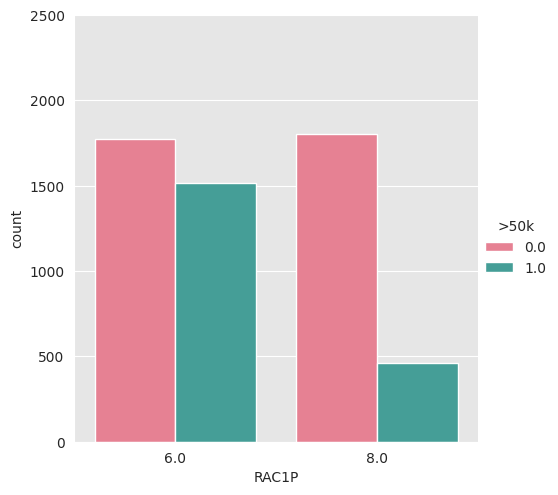

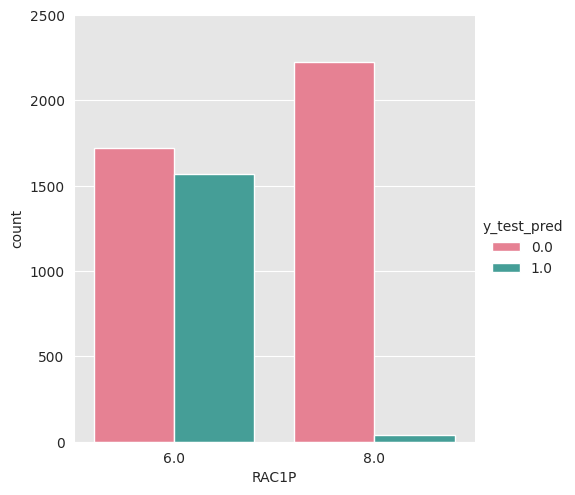

In [ ]:
sns.catplot(x="RAC1P", kind="count", hue=model_target, data=dpl_df, palette="husl")
plt.ylim(0, 2500)
sns.catplot(x="RAC1P", kind="count", hue="y_test_pred", data=dpl_df, palette="husl")
plt.ylim(0, 2500)
plt.show()

---
## Conclusion

The imbalance is not as drastic for the favored group where the predictions and ground truth bar charts look  similar. However, for the disfavored group, the predicted class is almost exclusively negative. If this model were put in production, group 8 would be at a further disadvantage.

Also, notice how the overall model performance (as measured in accuracy) is relatively high. This is because the outcomes are imbalanced with a lot more negative examples in total. Remember that this model was trained with the sensitive feature as part of the model features. You could try removing this to see if that leads to better outcomes for the disfavored group.